# Heart Disease Prediction Using Supervised Learning

The aim of this analysis is to develop a machine leanring model which can predict whether a patient is at high risk of experiencing heart disease. The dataset comprises 1,190 patient records with 11 features, including age, sex, and chest pain type, among others. The target variable, labeled 'class', indicates the prediction outcome, where 1 represents the presence of heart disease and 0 denotes a normal (healthy) condition.

Below is the detailed description of the dataset:


| S.No. | Attribute                            | Code given         | Unit                | Data type |
|-------|--------------------------------------|--------------------|---------------------|-----------|
| 1     | age                                  | Age                | in years           | Numeric   |
| 2     | sex                                  | Sex                | 1, 0               | Binary    |
| 3     | chest pain type                      | chest pain type    | 1,2,3,4            | Nominal   |
| 4     | resting blood pressure               | resting bp s       | in mm Hg           | Numeric   |
| 5     | serum cholesterol                    | cholesterol        | in mg/dl           | Numeric   |
| 6     | fasting blood sugar                  | fasting blood sugar| 1,0 > 120 mg/dl    | Binary    |
| 7     | resting electrocardiogram results    | resting ecg        | 0,1,2              | Nominal   |
| 8     | maximum heart rate achieved          | max heart rate     | 71–202             | Numeric   |
| 9     | exercise induced angina              | exercise angina    | 0,1                | Binary    |
| 10    | oldpeak = ST                         | oldpeak            | depression         | Numeric   |
| 11    | the slope of the peak exercise ST segment | ST slope       | 0,1,2             | Nominal   |
| 12    | class                                | target             | 0,1                | Binary    |


## Exploratory Data Analysis

In [66]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import RFE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [67]:
heart_attack = pd.read_csv("heart_statlog_cleveland_hungary_final.csv")

In [68]:
print(heart_attack.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1190 entries, 0 to 1189
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  1190 non-null   int64  
 1   sex                  1190 non-null   int64  
 2   chest pain type      1190 non-null   int64  
 3   resting bp s         1190 non-null   int64  
 4   cholesterol          1190 non-null   int64  
 5   fasting blood sugar  1190 non-null   int64  
 6   resting ecg          1190 non-null   int64  
 7   max heart rate       1190 non-null   int64  
 8   exercise angina      1190 non-null   int64  
 9   oldpeak              1190 non-null   float64
 10  ST slope             1190 non-null   int64  
 11  target               1190 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 111.7 KB
None


In [69]:
print(heart_attack.head())

   age  sex  chest pain type  resting bp s  cholesterol  fasting blood sugar  \
0   40    1                2           140          289                    0   
1   49    0                3           160          180                    0   
2   37    1                2           130          283                    0   
3   48    0                4           138          214                    0   
4   54    1                3           150          195                    0   

   resting ecg  max heart rate  exercise angina  oldpeak  ST slope  target  
0            0             172                0      0.0         1       0  
1            0             156                0      1.0         2       1  
2            1              98                0      0.0         1       0  
3            0             108                1      1.5         2       1  
4            0             122                0      0.0         1       0  


The dataset has no missing value. However, according to the data definition, some columns such as "chest pain type", "resting ecg" and "ST slope" are categorical, but they are represented as integer in the raw dataset. We would like to convert them into the correct data type.

In [70]:
# Define a list of categorical columns
cat_cols = ["chest pain type", "resting ecg", "ST slope"]

# Convert these column into categorical
heart_attack[cat_cols] = heart_attack[cat_cols].astype("object")

Except for the target variable, all binary features should also be converted to the 'bool' data type.

In [71]:
# Define a list of binary columns
bool_cols = ["sex", "fasting blood sugar", "exercise angina"]

# Converting non-label binary columns into bool (convienient for rescaling numeric data later on).
heart_attack[bool_cols] = heart_attack[bool_cols].astype("bool")

We will now explore the distribution of the target label.

In [72]:
print("The relative frequency of each class in the target:")
relative_frequency = (heart_attack[['target']].value_counts() * 100 / len(heart_attack)).round(2)
print(relative_frequency)

The relative frequency of each class in the target:
target
1         52.86
0         47.14
Name: count, dtype: float64


It seems that the target variable is not severly imbalanced.

### Preprocessing

In [73]:
X = heart_attack.drop(columns = ["target"])
y = heart_attack["target"]

In [74]:
# Apply one-hot encoding to categorical columns
import pickle
X = pd.get_dummies(X)
with open('feature_names.pkl', 'wb') as f:
    pickle.dump(X.columns.tolist(), f)


In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('The shape of the training features: ', X_train.shape)
print('The shape of the training target: ', y_train.shape)
print('The shape of the testing features: ', X_test.shape)
print('The shape of the testing target: ', y_test.shape)

The shape of the training features:  (952, 19)
The shape of the training target:  (952,)
The shape of the testing features:  (238, 19)
The shape of the testing target:  (238,)


In [76]:
# Feature scaling for numeric columns
num_cols = X_train.select_dtypes(exclude = ['bool', 'object']).columns
print(num_cols)
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
X_test

Index(['age', 'resting bp s', 'cholesterol', 'max heart rate', 'oldpeak'], dtype='object')


,age,sex,resting bp s,cholesterol,fasting blood sugar,max heart rate,exercise angina,oldpeak,chest pain type_1,chest pain type_2,chest pain type_3,chest pain type_4,resting ecg_0,resting ecg_1,resting ecg_2,ST slope_0,ST slope_1,ST slope_2,ST slope_3
390,0.762066,True,1.521592,-2.102476,True,0.199342,False,0.086216,False,False,False,True,False,True,False,False,False,True,False
247,0.019826,True,-0.650481,0.271518,False,0.396899,True,0.542202,False,False,True,False,True,False,False,False,False,True,False
260,0.125860,False,-0.541877,1.102916,False,0.594455,False,-0.825757,False,True,False,False,True,False,False,False,True,False,False
155,0.231895,True,1.250082,1.323287,True,0.396899,True,1.910161,False,False,False,True,True,False,False,False,False,True,False
984,0.656032,False,0.978573,0.481872,False,0.673478,False,1.545372,False,False,False,True,False,False,True,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,0.549998,True,-0.378972,0.121265,False,-0.195772,True,1.454175,False,False,False,True,True,False,False,False,False,False,True
1037,-0.192243,True,1.087177,0.882546,True,1.503217,False,0.268610,True,False,False,False,True,False,False,False,False,True,False
812,0.125860,False,0.164046,0.401737,False,0.831524,False,0.451005,False,True,False,False,False,False,True,False,False,True,False
139,-1.146552,True,0.978573,0.371686,False,-0.393329,True,0.998189,False,False,False,True,True,False,False,False,False,True,False


In [77]:
heart_attack

,age,sex,chest pain type,resting bp s,cholesterol,fasting blood sugar,resting ecg,max heart rate,exercise angina,oldpeak,ST slope,target
0,40,True,2,140,289,False,0,172,False,0.0,1,0
1,49,False,3,160,180,False,0,156,False,1.0,2,1
2,37,True,2,130,283,False,1,98,False,0.0,1,0
3,48,False,4,138,214,False,0,108,True,1.5,2,1
4,54,True,3,150,195,False,0,122,False,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1185,45,True,1,110,264,False,0,132,False,1.2,2,1
1186,68,True,4,144,193,True,0,141,False,3.4,2,1
1187,57,True,4,130,131,False,0,115,True,1.2,2,1
1188,57,False,2,130,236,False,2,174,False,0.0,2,1


## Model Development

### a. Logistic Regression

In [78]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression()

In [79]:
# Evaluation on training and testing data: accuracy and f1-score
y_pred = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.87
f1-score score testing data: 0.88
Accuracy score training data: 0.84
f1-score score training data: 0.85


In [80]:
# Confusuin matrix
print("The confusion matrix for this logistic regression model is: ")
print(confusion_matrix(y_test, y_pred))

The confusion matrix for this logistic regression model is: 
[[ 89  18]
 [ 13 118]]


We will then perform feature engineering with recursive features elimination

In [81]:
accuracy_scores = []
f1_scores = []
for i in range(1, X_train.shape[1]+1):
    rfe = RFE(estimator=logreg, n_features_to_select=i)
    rfe.fit(X_train, y_train)
    y_pred = rfe.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

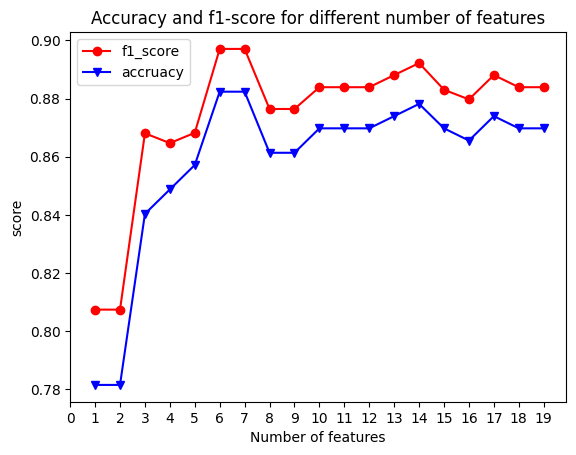

In [82]:
plt.plot(np.arange(1, X_train.shape[1] + 1), f1_scores, label = 'f1_score', color = 'r', marker = 'o')
plt.plot(np.arange(1, X_train.shape[1] + 1), accuracy_scores, label = 'accruacy', color = 'b', marker = 'v')
plt.xticks(ticks = np.arange(0, X_train.shape[1] + 1, 1.0))
plt.title('Accuracy and f1-score for different number of features')
plt.xlabel('Number of features')
plt.ylabel('score')
plt.legend()


Based on the chart above, it can be seen that 6 is the optimal number of features.

In [83]:
rfe = RFE(estimator=logreg, n_features_to_select=6)
rfe.fit(X_train, y_train)

# Prediction on the train and test set
y_pred = rfe.predict(X_test)
y_pred_train = logreg.predict(X_train)

#Model evaluation
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.88
f1-score score testing data: 0.90
Accuracy score training data: 0.84
f1-score score training data: 0.85


In [84]:
# Getting the retained features
retained_features = []
support = rfe.support_
for idx, feature in enumerate(X_train.columns):
    if support[idx]:
        retained_features.append(feature)
print(retained_features)

['sex', 'fasting blood sugar', 'exercise angina', 'chest pain type_4', 'ST slope_1', 'ST slope_2']


### b. K-Nearest Neighbors

We will start with K=1

In [85]:
one_nn = KNeighborsClassifier(n_neighbors = 1)
one_nn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [86]:
y_pred_train = one_nn.predict(X_train)
y_pred = one_nn.predict(X_test)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.88
f1-score score testing data: 0.89
Accuracy score training data: 1.00
f1-score score training data: 1.00


We now perform hyperparameter tuning for the hyperparameter K to avoid overfitting.

In [87]:
param_grid = {
    'n_neighbors': np.arange(1, 21).tolist(),
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='accuracy',  # Metric to optimize
    cv=5,                # 5-fold cross-validation
    n_jobs=-1,         # Use all CPUs
    return_train_score=True  # Ensures train scores are available
)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Best hyperparameters and performance
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters: {'n_neighbors': 1}
Best cross-validation accuracy: 0.8676550013777898


In [88]:
mean_train_score = grid_search.cv_results_['mean_train_score']
mean_test_score = grid_search.cv_results_['mean_test_score']

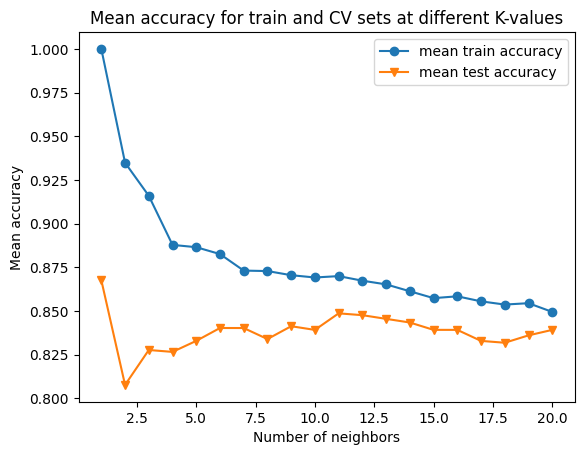

In [89]:
plt.plot(np.arange(1,21), mean_train_score, marker = 'o', label = 'mean train accuracy')
plt.plot(np.arange(1, 21), mean_test_score, marker = 'v', label = 'mean test accuracy')
plt.title('Mean accuracy for train and CV sets at different K-values')
plt.xlabel('Number of neighbors')
plt.ylabel('Mean accuracy')
plt.legend()

The highest performing KNN model has the K=1, and the model is still overfitting. Thus we will experiment with tree-based algorithms.

### Tree-based Algorithms

We will start by initialising a decision tree model with no regularisation, we expect the model to be overfitting.

In [90]:
dc_clf = DecisionTreeClassifier(random_state=42)
dc_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [91]:
y_pred_train = dc_clf.predict(X_train)
y_pred = dc_clf.predict(X_test)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.90
f1-score score testing data: 0.91
Accuracy score training data: 1.00
f1-score score training data: 1.00


The model is overfitting, let's see whether tuning the hyperparameter max_depth can reduce it.

In [92]:
param_max_depth = {'max_depth': np.arange(1, 15, 1).tolist()}
grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_max_depth,
    scoring='accuracy',       # Metric to optimize (e.g., 'accuracy', 'f1')
    cv=5,                   # Number of cross-validation folds             
    n_jobs=-1               # Number of parallel jobs (-1 uses all CPUs)
)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validation accuracy: {grid_search.best_score_:.2f}")

Best parameters: {'max_depth': 11}
Best cross-validation accuracy: 0.86


In [93]:
dc_clf = DecisionTreeClassifier(random_state = 42, max_depth = 11)
dc_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=11, random_state=42)

In [94]:
y_pred_train = dc_clf.predict(X_train)
y_pred = dc_clf.predict(X_test)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.88
f1-score score testing data: 0.89
Accuracy score training data: 0.99
f1-score score training data: 0.99


It seems that decision tree is prone to overfitting even with hyperparameter tuning. We will experiement with the Random Forest and the Adaptive Boosting algorithm.

In [95]:
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

rf_clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [96]:
y_pred_train = rf_clf.predict(X_train)
y_pred = rf_clf.predict(X_test)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")

Accuracy score testing data: 0.95
f1-score score testing data: 0.96
Accuracy score training data: 1.00
f1-score score training data: 1.00


In [97]:
# Import AdaBoostClassifier
from sklearn.ensemble import AdaBoostClassifier


In [98]:
ada = AdaBoostClassifier(estimator = dc_clf, n_estimators = 200, random_state = 42)
ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=11,
                                                    random_state=42),
                   n_estimators=200, random_state=42)

In [99]:
y_pred_train = ada.predict(X_train)
y_pred = ada.predict(X_test)
print(f"Accuracy score testing data: {accuracy_score(y_test, y_pred):.2f}")
print(f"f1-score score testing data: {f1_score(y_test, y_pred):.2f}")
print(f"Accuracy score training data: {accuracy_score(y_train, y_pred_train):.2f}")
print(f"f1-score score training data: {f1_score(y_train, y_pred_train):.2f}")


Accuracy score testing data: 0.95
f1-score score testing data: 0.95
Accuracy score training data: 1.00
f1-score score training data: 1.00


It seems that both the Random Forest and Adaptive Boosting algorithm can perform extremely well on this dataset, we will deploy 'ada' as our final model.

In [100]:
import pickle
with open('heartattack.pkl', 'wb') as f:
  pickle.dump(ada, f)

In [101]:
scaler = StandardScaler()
scaler.fit(X)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

In [102]:
import numpy as np
import sklearn

print("Numpy version:", np.__version__)
print("Scikit-learn version:", sklearn.__version__)

Numpy version: 2.2.0
Scikit-learn version: 1.6.0


### Reference

Manu Siddhartha. (2020). Heart Disease Dataset (Comprehensive). IEEE Dataport. https://dx.doi.org/10.21227/dz4t-cm36